# Neural networks demo: predict

CPSC 340: Machine Learning and Data Mining

The University of British Columbia

2017 Winter Term 2

Mike Gelbart

In [3]:
import numpy as np
import numpy.random as npr
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from sklearn.neural_network import MLPRegressor

%autosave 0

Autosave disabled


Consider 1-d regression...

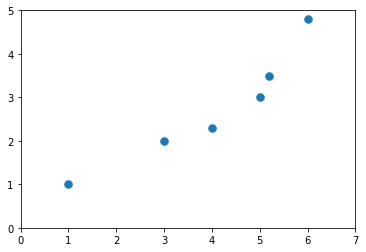

In [3]:
x = np.array([1,3,4,  5,5.2,6])
y = np.array([1,2,2.3,3,3.5,4.8])    
def plot_pts(x,y):
    plt.plot(x,y, '.', markersize=15)
    plt.xlim([0, 7])
    plt.ylim([0, 5])
plot_pts(x,y)

Consider various fits... 

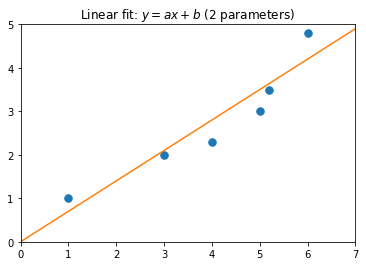

In [4]:
plot_pts(x,y)
grid = np.linspace(0,7,100)
plt.plot(grid,0.7*grid)
plt.title("Linear fit: $y=ax+b$ (2 parameters)");

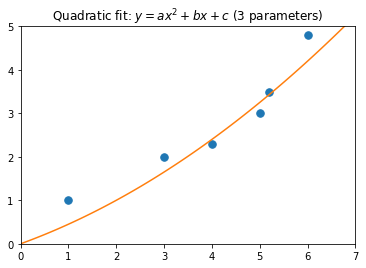

In [5]:
plot_pts(x,y)
plt.plot(grid,0.4*grid+0.05*grid**2)
plt.title("Quadratic fit: $y=ax^2+bx+c$ (3 parameters)");

We can fit various functions from the _polynomial family_. But each polynomial **has a different number of parameters**. Note that the polynomial family always maps from $\mathbb{R}^D\rightarrow \mathbb{R}$.

- Model: has parameters that we fit
- Family: a set of models that are linked by some theme, but may have different numbers of parameters
- **"Neural network" is a family of functions just like this.**


In [80]:
def example_1_layer_nn(x,W,f): # x is a vector, W is a matrix
    return f(W@x)

x = np.random.rand(5)
W = np.random.rand(2,5)
f = lambda x: 1/(1+np.exp(-x))

example_1_layer_nn(x,W,f)

array([0.69557408, 0.7560446 ])

Above, the size of the input is 5 and the size of the output is 2.

In [81]:
def example_nn(x,W,f): # x is a vector, W is a _list of matrices_
    for W_l in W:
        x = f(W_l@x)
    return x

x = np.random.rand(5)
W1 = np.random.rand(2,5)
W2 = np.random.rand(1,2)
example_nn(x, [W1,W2], f)

array([0.77899381])

Above, the size of the input is 5 and the size of the output is 1.

#### How many parameters do we have?

Just the weight matrices: $$d_0d_1 + d_1d_2 + \ldots + d_{L-1}d_L$$

With the biases: $$(d_0+1)d_1 + (d_1+1)d_2 + \ldots + (d_{L-1}+1)d_L$$

**This is potentially a lot of parameters!!!!**

#### Some neural net code

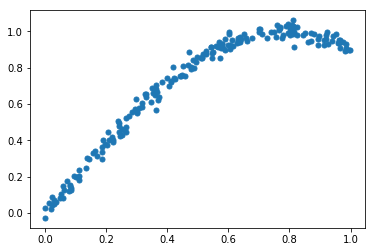

In [16]:
# generate synthetic data
npr.seed(5)
n = 200
X = npr.rand(n,1)
y = np.sin(2*X[:,0]) + np.random.randn(n)*0.03

plt.figure()
plt.plot(X,y,'.',markersize=10);

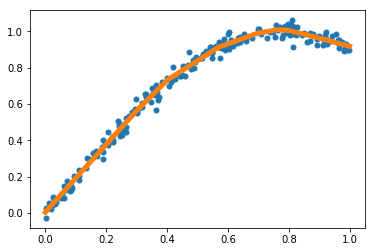

In [22]:
nn = MLPRegressor(solver='lbfgs')
nn.fit(X,y);

plt.plot(X,y,'.',markersize=10);
grid = np.linspace(0,1,1000)[:,None]

plt.plot(grid, nn.predict(grid),linewidth=5);

#### random weights

To build intuition about the types of functions we can represent, let's explore what happens with random weights using different architectures. Again, this is all within the confines of $\mathbb{R}\rightarrow\mathbb{R}$ which isn't the real deal.


//anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


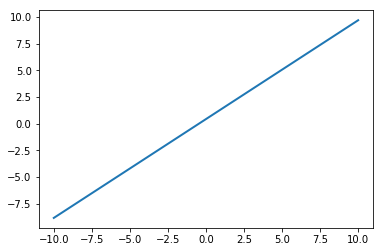

In [65]:
nn = MLPRegressor(hidden_layer_sizes=(), activation='logistic',max_iter=1)

# change hidden_layer_sizes to, e.g. 10,
# change activation to relu

nn.fit(np.zeros((1,1)),[0])
grid = np.linspace(-10,10,1000)[:,None]
plt.plot(grid, nn.predict(grid),linewidth=2);

Regression example with $d=2$

//anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


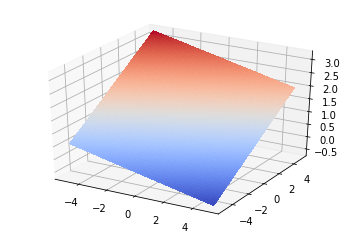

In [79]:
nn = MLPRegressor(hidden_layer_sizes=(), max_iter=1)

nn.fit(np.zeros((1,2)),[0])
fig=plt.figure()
ax = fig.gca(projection='3d')

ngrid = 100
X = np.linspace(-5, 5, ngrid)
Y = np.linspace(-5, 5, ngrid)
X, Y = np.meshgrid(X, Y)

inputs = np.append(X.flatten()[:,None], Y.flatten()[:,None],axis=1)
outputs = nn.predict(inputs)
Z = np.reshape(outputs, [ngrid,ngrid])

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

## Some deep learning software

There's been a lot of software released lately to take care of this for you. Some big players are:

| Name   |  Host language  | Released |
|--------|-------------|---------------|
| [Torch](http://torch.ch) | Lua | 2002 |
| [Theano](http://deeplearning.net/software/theano/) | Python | 2007 |
| [Caffe](http://caffe.berkeleyvision.org) | Executable with Python wrapper | 2014 |
| [TensorFlow](https://www.tensorflow.org) | Python | 2015 |
| [Keras](https://keras.io) | Python | 2015 |
| [PyTorch](http://pytorch.org) | Python | 2017 |
| [Caffe 2](https://caffe2.ai/) | Python or C++ | 2017 |

There are many others. See for example [Comparison of deep learning software].(https://en.wikipedia.org/wiki/Comparison_of_deep_learning_software).

#### Repeating the examples above in Keras

In [1]:
from keras.models import Sequential
from keras.layers import Dense
import keras

//anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# generate fake data
npr.seed(5)
N = 200
X = npr.rand(N,1)
y = np.sin(2*X) + npr.randn(N,1)*0.03


In [5]:
model = Sequential()
model.add(Dense(10, input_dim=1, activation='tanh', kernel_initializer='lecun_uniform',))
model.add(Dense(1, activation='linear', kernel_initializer='lecun_uniform',))

# Compile model
sgd = keras.optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='mean_squared_error', optimizer=sgd)#'adam')

# Fit the model
loss=model.evaluate(X, y,verbose=0)
print(loss)
model.fit(X, y, epochs=1000, verbose=0)

# evaluate the model
loss=model.evaluate(X, y,verbose=0)
print(loss)


1.1753783893585206
0.0010298730968497692


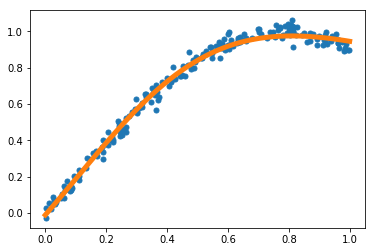

In [8]:
plt.plot(X,y,'.',markersize=10)
grid = np.linspace(0,1,1000)[:,None]
plt.plot(grid, model.predict(grid),linewidth=5);

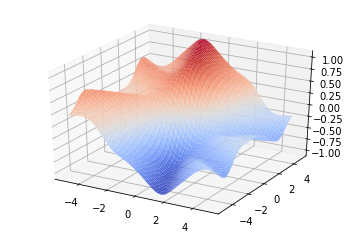

In [9]:
# random weights
model = Sequential()
model.add(Dense(50, input_dim=2, activation='tanh', kernel_initializer='lecun_uniform'))
model.add(Dense(1, activation='linear', kernel_initializer='lecun_uniform',))
model.compile(loss='mean_squared_error', optimizer='sgd')

fig = plt.figure()
ax = fig.gca(projection='3d')

n = 100
X = np.linspace(-5, 5, n)
Y = np.linspace(-5, 5, n)
X, Y = np.meshgrid(X, Y)

inputs = np.append(X.flatten()[:,None], Y.flatten()[:,None],axis=1)
outputs = model.predict(inputs)
Z = np.reshape(outputs, [n,n])

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
